<a href="https://colab.research.google.com/github/MittalNeha/Extensive_Vision_AI6/blob/main/week4/Session_4_Neha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
!pip install hiddenlayer
import hiddenlayer as hl

# New Section

In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# model = Net().to(device)
# summary(model, input_size=(1, 28, 28))

#Download the dataset


In [4]:
torch.manual_seed(1)
# batch_size = 128
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


##Augmentation

In [5]:
len(train_loader.dataset)/128

468.75

In [6]:
from tqdm.notebook import tqdm
# def train(model, device, train_loader, optimizer, epoch):
#     model.train()
#     # pbar = tqdm(train_loader)
#     train_loss = 0
#     correct = 0
#     # for batch_idx, (data, target) in enumerate(pbar):
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = F.nll_loss(output, target)
#         loss.backward()
#         optimizer.step()
#         # pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

#         train_loss += loss
#         pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#         correct += pred.eq(target.view_as(pred)).sum().item()

#     train_loss /= len(train_loader.dataset)
#     hist_train_loss.append(train_loss)
#     hist_train_acc.append(100. * correct / len(train_loader.dataset))
#     print("Training Average loss: {:.4f}, Accuraacy = ({:.5f}%)\n".format(train_loss, 100. * correct / len(train_loader.dataset)))


#Use scheduler
def train(model, device, train_loader, optimizer, scheduler, epoch):
    model.train()
    # pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    num_loops = 0
    # for batch_idx, (data, target) in enumerate(pbar):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        # pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        num_loops +=1

    
    train_loss /= num_loops
    # scheduler.step()
    scheduler.step(train_loss)
    hist_train_loss.append(train_loss)
    hist_train_acc.append(100. * correct / len(train_loader.dataset))
    print(num_loops)
    print("Training Average loss: {:.6f}, Accuracy = ({:.6f}%)".format(train_loss, 100. * correct / len(train_loader.dataset)))




def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    hist_test_loss.append(test_loss)
    hist_test_acc.append(100. * correct / len(test_loader.dataset))

    print('Test set: Average loss: {:.6f}, Accuracy: {}/{} ({:.6f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [7]:
def draw_network(model):
  model = model.to("cpu")
  hl_graph = hl.build_graph(model, torch.zeros([1, 1, 28, 28]))
  # Use a different color theme
  hl_graph.theme = hl.graph.THEMES["blue"].copy()
  return hl_graph

In [8]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 6]

def training_curves():
  plt.subplot(1,2, 1)

  plt.plot(np.array(hist_test_acc))
  plt.plot(np.array(hist_train_acc), 'r')
  plt.legend(["test_acc", "train_acc"])
  plt.title("Accuracy per epoch")

  plt.subplot(1,2,2)
  plt.plot(hist_test_loss)
  plt.plot(hist_train_loss, 'r')
  plt.legend(["test_loss", "train_loss"])
  plt.title("Loss per epoch")


In [9]:
drop_out_val = 0.1
class Net7(nn.Module):
    def __init__(self):
        super().__init__()                     #Input - Output - RF
        self.conv1 = nn.Conv2d(1, 12, 3, padding=1)      #28 - 28 - 3x3
        self.bn1 = nn.BatchNorm2d(12)
        self.do1 = nn.Dropout2d(drop_out_val)
        
        self.conv2 = nn.Conv2d(12, 24, 3, padding=1)      #28 - 26 - 5x5
        self.bn2 = nn.BatchNorm2d(24)
        self.do2 = nn.Dropout2d(drop_out_val)
        
        # self.conv2_1 = nn.Conv2d(24,24, 3, padding=1)             #26 - 24 - 7x7
        # self.conv2_2 = nn.Conv2d(36, 24, 1)             #24 - 24 - 7x7
        self.pool1 = nn.MaxPool2d(2, 2)                 #28 - 14 - 14x14

        self.conv3 = nn.Conv2d(24, 12, 1)               #12 - 10 - 12x12
        self.bn3 = nn.BatchNorm2d(12)
        self.do3 = nn.Dropout2d(drop_out_val)

        self.conv4 = nn.Conv2d(12, 24, 3, padding = 1)              #10 - 8 - 14x14
        self.bn4 = nn.BatchNorm2d(24)
        self.do4 = nn.Dropout2d(drop_out_val)

        self.conv4_1 = nn.Conv2d(24, 24, 3, padding = 1)           #8 - 8 - 14x14
        self.bn4_1 = nn.BatchNorm2d(24)
        self.do4_1 = nn.Dropout2d(drop_out_val)

        self.pool2 = nn.MaxPool2d(2, 2)                 #8 -  4 - 28x28
        self.conv5 = nn.Conv2d(24, 12, 1)             #4  -  2 - 30x30
        self.bn5 = nn.BatchNorm2d(12)
        self.do5 = nn.Dropout2d(drop_out_val)

        self.conv6 = nn.Conv2d(12, 24, 3, padding = 1)            #3 -   1 - 32x32
        self.bn6 = nn.BatchNorm2d(24)
        self.do6 = nn.Dropout2d(drop_out_val)

        self.conv6_1 = nn.Conv2d(24, 24, 3, padding = 1)            #3 -   1 - 32x32
        # self.bn6_1 = nn.BatchNorm2d(24)
        self.do6_1 = nn.Dropout2d(drop_out_val)

        self.gap = nn.AvgPool2d(7)
        self.linear1 = nn.Linear(24, 10)

    def forward(self, x):
        #self is containing all variables, compulsory to pass
        #x is input image
        # CONV/FC -> BatchNorm -> ReLu(or other activation) -> Dropout 
        x = self.pool1(self.do2(F.relu(self.bn2(self.conv2(self.do1(F.relu( self.bn1(self.conv1(x)))))))))   #conv1 -> ReLU -> conv2 -> ReLU -> max pool
        x = self.pool2(self.do4_1(F.relu( self.bn4_1(self.conv4_1(self.do4(F.relu( self.bn4(self.conv4(self.do3(F.relu( self.bn3(self.conv3(x)))))))))))))   #conv3 -> ReLU -> conv4 -> ReLU -> max pool
        x =                       F.relu( self.conv6_1(self.do6(F.relu( self.bn6(self.conv6(self.do5(F.relu( self.bn5(self.conv5(x))))))))))               #conv5 -> ReLU -> conv6 -> ReLU
        x = self.gap(x)
        x = x.view(-1, 24)
        x = self.linear1(x)
        return F.log_softmax(x)       #log of softmax

# model = Net7().to(device)

## Net 8
12->24->MP->12->12->24->MP->12->12->24->GAP->Dense->10

In [26]:
# drop_out_val = 0.1
drop_out_val = 0.05
class Net8(nn.Module):
    def __init__(self):
        super().__init__()                     #Input - Output - RF
        self.conv1 = nn.Conv2d(1, 12, 3, padding=1)      #28 - 28 - 3x3
        self.bn1 = nn.BatchNorm2d(12)
        self.do1 = nn.Dropout2d(drop_out_val)
        
        self.conv2 = nn.Conv2d(12, 24, 3, padding=1)      #28 - 26 - 5x5
        self.bn2 = nn.BatchNorm2d(24)
        self.do2 = nn.Dropout2d(drop_out_val)
        
        # self.conv2_1 = nn.Conv2d(24, 24, 3, padding=1)             #26 - 24 - 7x7
        # self.bn2_1 = nn.BatchNorm2d(24)
        # self.do2_1 = nn.Dropout2d(drop_out_val)

        # self.conv2_2 = nn.Conv2d(36, 24, 1)             #24 - 24 - 7x7
        self.pool1 = nn.MaxPool2d(2, 2)                 #28 - 14 - 14x14

        self.conv3 = nn.Conv2d(24, 12, 1)               #12 - 10 - 12x12
        self.bn3 = nn.BatchNorm2d(12)
        self.do3 = nn.Dropout2d(drop_out_val)

        self.conv4 = nn.Conv2d(12, 12, 3, padding = 1)              #10 - 8 - 14x14
        self.bn4 = nn.BatchNorm2d(12)
        self.do4 = nn.Dropout2d(drop_out_val)

        self.conv4_1 = nn.Conv2d(12, 24, 3, padding = 1)           #8 - 8 - 14x14
        self.bn4_1 = nn.BatchNorm2d(24)
        self.do4_1 = nn.Dropout2d(drop_out_val)

        self.pool2 = nn.MaxPool2d(2, 2)                 #8 -  4 - 28x28
        self.conv5 = nn.Conv2d(24, 12, 1)             #4  -  2 - 30x30
        self.bn5 = nn.BatchNorm2d(12)
        self.do5 = nn.Dropout2d(drop_out_val)

        self.conv6 = nn.Conv2d(12, 12, 3, padding = 1)            #3 -   1 - 32x32
        self.bn6 = nn.BatchNorm2d(12)
        self.do6 = nn.Dropout2d(drop_out_val)

        self.conv6_1 = nn.Conv2d(12, 24, 3, padding = 1)            #3 -   1 - 32x32
        self.bn6_1 = nn.BatchNorm2d(24)
        self.do6_1 = nn.Dropout2d(drop_out_val)

        #self.conv7 = nn.Conv2d(128, 10, 3)             #3 -   1 - 34x34
        self.gap = nn.AvgPool2d(7)
        self.linear1 = nn.Linear(24, 10)
        # self.do = nn.Dropout(0.25)
        # self.linear2 = nn.Linear(48, 10)

    def forward(self, x):
        #self is containing all variables, compulsory to pass
        #x is input image
        # CONV/FC -> BatchNorm -> ReLu(or other activation) -> Dropout 
        # x = self.pool1(self.do2_1(F.relu(self.bn2_1(self.conv2_1(self.do2(F.relu(self.bn2(self.conv2(self.do1(F.relu( self.bn1(self.conv1(x))))))))) ))))  #conv1 -> ReLU -> conv2 -> ReLU -> max pool
        # x = self.pool2(self.do4_1(F.relu( self.bn4_1(self.conv4_1(self.do4(F.relu( self.bn4(self.conv4(self.do3(F.relu( self.bn3(self.conv3(x)))))))))))))   #conv3 -> ReLU -> conv4 -> ReLU -> max pool
        # x =                       F.relu( self.conv6_1(self.do6(F.relu( self.bn6(self.conv6(self.do5(F.relu( self.bn5(self.conv5(x))))))))))               #conv5 -> ReLU -> conv6 -> ReLU
        
        #BN after Relu
        x = self.pool1(self.do2(self.bn2(F.relu(self.conv2(self.do1(self.bn1(F.relu(self.conv1(x)))))))))  #conv1 -> ReLU -> conv2 -> ReLU -> max pool
        x = self.pool2(self.do4_1( self.bn4_1(F.relu(self.conv4_1(self.do4(self.bn4(F.relu(self.conv4(self.do3( self.bn3(F.relu(self.conv3(x)))))))))))))   #conv3 -> ReLU -> conv4 -> ReLU -> max pool
        x =                       F.relu( self.conv6_1(self.do6(self.bn6(F.relu(self.conv6(self.do5(self.bn5(F.relu(self.conv5(x))))))))))               #conv5 -> ReLU -> conv6 -> ReLU
        
        x = self.gap(x)
        x = x.view(-1, 24)
        x = self.linear1(x)
        # x = self.linear2(self.do(F.relu(self.linear1(x))))
        return F.log_softmax(x)       #log of softmax

model = Net8().to(device)

## Summary and training

In [27]:
summary(model, input_size=(1, 28, 28))
# graph = draw_network(model)
# graph

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 28, 28]             120
       BatchNorm2d-2           [-1, 12, 28, 28]              24
         Dropout2d-3           [-1, 12, 28, 28]               0
            Conv2d-4           [-1, 24, 28, 28]           2,616
       BatchNorm2d-5           [-1, 24, 28, 28]              48
         Dropout2d-6           [-1, 24, 28, 28]               0
         MaxPool2d-7           [-1, 24, 14, 14]               0
            Conv2d-8           [-1, 12, 14, 14]             300
       BatchNorm2d-9           [-1, 12, 14, 14]              24
        Dropout2d-10           [-1, 12, 14, 14]               0
           Conv2d-11           [-1, 12, 14, 14]           1,308
      BatchNorm2d-12           [-1, 12, 14, 14]              24
        Dropout2d-13           [-1, 12, 14, 14]               0
           Conv2d-14           [-1, 24,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [13]:
#reset the Network
model = Net8().to(device)

In [28]:
hist_test_loss = []
hist_test_acc = []
hist_train_loss = []
hist_train_acc = []

In [15]:
# model = model.to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,)
# # optimizer = optim.Adam(model.parameters(), lr=0.01)

# for epoch in range(1, 20):
#     print("Epoch: ", epoch)
#     train(model, device, train_loader, optimizer, epoch)
#     test(model, device, test_loader)
# training_curves()

Model with schedular

In [16]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR

Epoch:  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


938
Training Average loss: 0.311708, Accuracy = (90.015000%)
learning rate 0.1
Test set: Average loss: 0.069209, Accuracy: 9787/10000 (97.870000%)

Epoch:  2
938
Training Average loss: 0.102386, Accuracy = (96.946667%)
learning rate 0.1
Test set: Average loss: 0.044042, Accuracy: 9861/10000 (98.610000%)

Epoch:  3
938
Training Average loss: 0.076846, Accuracy = (97.681667%)
learning rate 0.1
Test set: Average loss: 0.035034, Accuracy: 9879/10000 (98.790000%)

Epoch:  4
938
Training Average loss: 0.065113, Accuracy = (98.100000%)
learning rate 0.1
Test set: Average loss: 0.037348, Accuracy: 9878/10000 (98.780000%)

Epoch:  5
938
Training Average loss: 0.058749, Accuracy = (98.251667%)
learning rate 0.1
Test set: Average loss: 0.032957, Accuracy: 9889/10000 (98.890000%)

Epoch:  6
938
Training Average loss: 0.054645, Accuracy = (98.340000%)
learning rate 0.1
Test set: Average loss: 0.033955, Accuracy: 9891/10000 (98.910000%)

Epoch:  7
938
Training Average loss: 0.052733, Accuracy = (98.

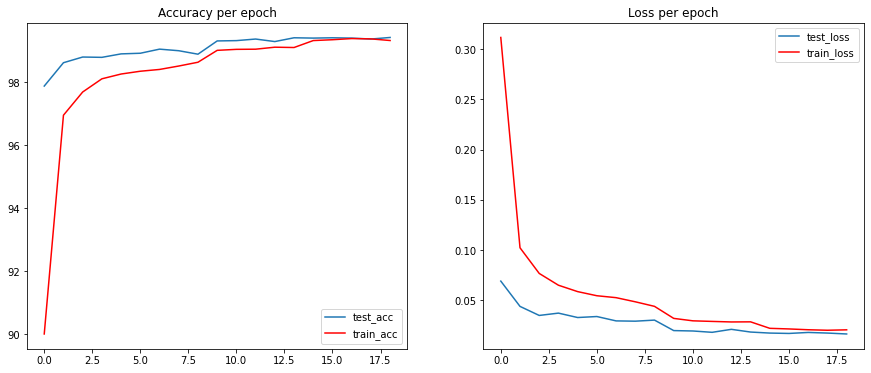

In [29]:
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9,)

scheduler =ReduceLROnPlateau(optimizer=optimizer, patience=2, verbose=True)

for epoch in range(1, 10):
    print("Epoch: ", epoch)
    train(model, device, train_loader, optimizer, scheduler, epoch)
    print("learning rate", optimizer.param_groups[0]['lr'])
    test(model, device, test_loader)

optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
for epoch in range(10, 15):
    print("Epoch: ", epoch)
    train(model, device, train_loader, optimizer, scheduler, epoch)
    print("learning rate", optimizer.param_groups[0]['lr'])
    test(model, device, test_loader)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,)
for epoch in range(15, 20):
    print("Epoch: ", epoch)
    train(model, device, train_loader, optimizer, scheduler, epoch)
    print("learning rate", optimizer.param_groups[0]['lr'])
    test(model, device, test_loader)   

# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,)
# for epoch in range(15, 20):
#     print("Epoch: ", epoch)
#     train(model, device, train_loader, optimizer, scheduler, epoch)
#     print("learning rate", optimizer.param_groups[0]['lr'])
#     test(model, device, test_loader)   
training_curves()

More epochs with lower LR